In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from fuzzywuzzy import fuzz

In [2]:
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [3]:
df = pd.read_csv("./train.csv")

#print(df.corr())
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


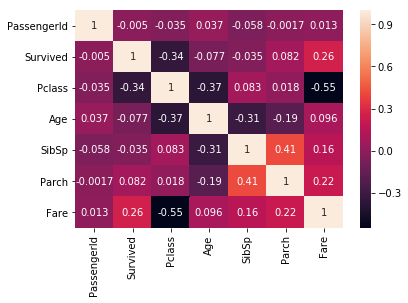

In [4]:
import seaborn as sns
#sns.pairplot(df,hue="Survived")
sns.heatmap(df.corr(),annot=True)

# Defining Age
#df=fare_process(df)
#df["Sex"][df["Age"].isnull() & df["Survived"] == 1].value_counts()

#df[df["Cabin"].isnull() == True].count()

In [5]:
Y=pd.DataFrame(to_categorical(df["Survived"]))
Y.isnull().any()

0    False
1    False
dtype: bool

In [6]:
def createdummy(df,colname):
    dummies= pd.get_dummies(df[colname],prefix=colname)
    df=pd.concat([df,dummies],axis=1)
    return dummies


def pclass_process(df):
    df["Pclass"]=df["Pclass"].fillna(3)
    return createdummy(df,"Pclass")


def fare_process(df):
    df["Fare"]=df["Fare"].fillna(0)
    cutpoints=[-1,10,20,30,45,66,90,500]
    labels=['a','b','c','d','e','f','g']
    df["Fare1"]=pd.cut(df["Fare"],cutpoints,labels=labels)
    #return df
    return createdummy(df,"Fare1")


def embarked_process(df):
    #df["Embarked"].value_counts()
    df["Embarked"] = df["Embarked"].fillna("S")
    return createdummy(df,"Embarked")


def age_process(df):
    df["Age"]=df["Age"].fillna(-0.5)
    cutpoints=[-1,0,5,12,18,35,60,150]
    labels=["Missing","Infant","Child","Teenager","Young","Adult","Senior"]
    df["Age1"] = pd.cut(df["Age"],cutpoints,labels=labels)
    return createdummy(df,"Age1")


def sex_process(df):
        df["Sex"]=df["Sex"].fillna("male")
        return createdummy(df,"Sex")
    
    
def name_process(df):
    for i in range(len(df)):
        df.loc[i, ("NameInn")] =0
        if 100 == fuzz.partial_ratio("Mr.",df["Name"][i]):
            df.loc[i, ("NameInn")] =1
        elif 100 == fuzz.partial_ratio("Mrs.",df["Name"][i]):
            df.loc[i, ("NameInn")] =2
        elif 100 == fuzz.partial_ratio("Miss.",df["Name"][i]):
            df.loc[i, ("NameInn")] =3
        elif 100 == fuzz.partial_ratio("Master.",df["Name"][i]):
            df.loc[i, ("NameInn")] =4
        # to check values, out of loop
        #print(df["NameInn"].value_counts())
    return createdummy(df,"NameInn")


def family_size(df):
    df["FamilySize"]=df["SibSp"] + df["Parch"]
    return createdummy(df,"FamilySize")

In [7]:
df1 =pclass_process(df)
df2=fare_process(df)
df3=embarked_process(df)
df4=age_process(df)
df5=sex_process(df)
df6=name_process(df)
df7=family_size(df)

X=pd.concat([df["SibSp"],df["Parch"],df1,df2,df3,df4,df5,df6,df7],axis=1)


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.values,Y,test_size=0.1)
X_train.shape

(801, 38)

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,RMSprop
import keras.backend as K

K.clear_session()
model= Sequential()
model.add(Dense(30,input_shape=(38 ,), activation="relu"))
model.add(Dense(12,activation="relu"))
model.add(Dense(8,activation="relu"))
model.add(Dense(2,activation="softmax"))

model.compile(Adam(lr=0.001), "categorical_crossentropy",metrics=["accuracy"])
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                1170      
_________________________________________________________________
dense_2 (Dense)              (None, 12)                372       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 18        
Total params: 1,664
Trainable params: 1,664
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Set a learning rate annealer
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
lr_reduction= ReduceLROnPlateau(monitor='val_loss',factor=0.6, min_lr=0.00001,patience=1,verbose=1)

history= model.fit(X_train,y_train,batch_size=32,epochs=40,validation_split=0.1,callbacks=[lr_reduction])

Train on 720 samples, validate on 81 samples
Epoch 1/40
720/720 [==============================] - 1s 1ms/step - loss: 0.5826 - acc: 0.6917 - val_loss: 0.5282 - val_acc: 0.7407
Epoch 2/40
720/720 [==============================] - 0s 86us/step - loss: 0.5339 - acc: 0.7611 - val_loss: 0.5015 - val_acc: 0.8025
Epoch 3/40
720/720 [==============================] - 0s 76us/step - loss: 0.5066 - acc: 0.8069 - val_loss: 0.4871 - val_acc: 0.7901
Epoch 4/40
720/720 [==============================] - 0s 105us/step - loss: 0.4860 - acc: 0.8167 - val_loss: 0.4722 - val_acc: 0.8025
Epoch 5/40
720/720 [==============================] - 0s 112us/step - loss: 0.4684 - acc: 0.8236 - val_loss: 0.4630 - val_acc: 0.8025
Epoch 6/40
720/720 [==============================] - 0s 103us/step - loss: 0.4516 - acc: 0.8306 - val_loss: 0.4553 - val_acc: 0.8272
Epoch 7/40
720/720 [==============================] - 0s 94us/step - loss: 0.4357 - acc: 0.8306 - val_loss: 0.4476 - val_acc: 0.8148
Epoch 8/40
720/720 [==

Test Accuracy: 0.833333333333


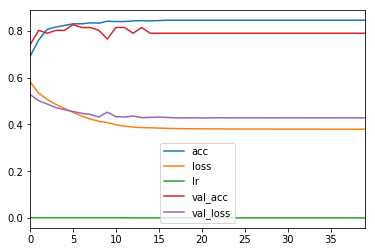

In [11]:
y_pred=model.predict(X_test)
y_predd=np.argmax(y_pred,axis=1)
y_testt=np.argmax(y_test.values,axis=1)
#print(y_predd)
print("Test Accuracy:",accuracy_score(y_testt,y_predd) )

historydf= pd.DataFrame(history.history, index=history.epoch)
historydf.plot()

In [12]:
# Starting with test part

df_tst = pd.read_csv("./test.csv")

df1_tst =pclass_process(df_tst)
df2_tst=fare_process(df_tst)
df3_tst=embarked_process(df_tst)
df4_tst=age_process(df_tst)
df5_tst=sex_process(df_tst)
df6_tst=name_process(df_tst)
df7_tst=family_size(df_tst)


X_tst=pd.concat([df_tst["SibSp"],df_tst["Parch"],df1_tst,df2_tst,df3_tst,df4_tst,df5_tst,df6_tst,df7_tst],axis=1)

y_tst_pred=model.predict(X_tst)
y_result=np.argmax(y_tst_pred,axis=1)


In [13]:
y_result
final_results=pd.concat([df_tst["PassengerId"], pd.DataFrame(y_result)],axis=1)
final_results.to_csv("res.csv")
